In [1]:
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Arial unicode MS']

LIST_EDGE = ['gneE0', 'gneE1', 'gneE2', 'gneE3', 'gneE4', 'gneE5', 'gneE6', 'gneE7', 'gneE8', 'gneE9',
             'gneE10', 'gneE11', 'gneE12', 'gneE13', 'gneE14', 'gneE15', 'gneE16', 'gneE17', 'gneE18', 'gneE19',
             'gneE20', 'gneE21', 'gneE22', 'gneE23', 'gneE24', 'gneE25', 'gneE26', 'gneE27', 'gneE28', 'gneE29',
             'gneE30', 'gneE31', 'gneE32', 'gneE33', 'gneE34', 'gneE35', 'gneE36', 'gneE37', 'gneE38', 'gneE39',
             'gneE40', 'gneE41']

In [2]:
def read_pkl(path, fname):
    with open(path + fname, 'rb') as f:
        data = pickle.load(f)
    column_names = ['veh_1', 'veh_2', 'cav_1', 'cav_2', 'platoon', 'processus', 'teleported', 'arrived', 'danger_try', 'faillure', 'collision', 'processus_lance', 'n_wrong', 'platoon_record']
    p_dist = []
    df_list = []
    for i in range(len(data)):
        l = data[i]
        df_eval = DataFrame(columns=column_names)
        df_eval['veh_1'] = np.array(l[0][0][0:1700])
        df_eval['veh_2'] = np.array(l[0][1][0:1700])
        df_eval['cav_1'] = np.array(l[1][0][0:1700])
        df_eval['cav_2'] = np.array(l[1][1][0:1700])
        df_eval['platoon'] = np.array(l[2][0:1700])
        df_eval['processus'] = np.array(l[3][0:1700])
        df_eval['teleported'] = np.array(l[4][0:1700])
        df_eval['arrived'] = np.array(l[5][0:1700])
        df_eval['danger_try'] = np.array(l[6][0:1700])
        df_eval['faillure'] = np.array(l[7][0:1700])
        df_eval['collision'] = np.array(l[8][0:1700])
        df_eval['processus_lance'] = np.array(l[9][0:1700])
        df_eval['n_wrong'] = np.array(l[11])
        for edge in LIST_EDGE:
            if edge in l[10].keys():
                record_e = np.array(l[10][edge])
                df_eval['n_platoon_' + edge] = np.array(record_e[:1700, 0])
                df_eval['l_platoon_' + edge] = np.array(record_e[:1700, 1])
                df_eval['n_cav_' + edge] = np.array(record_e[:1700, 2])
        # print(df_eval.columns)
        for t in range(42):
            df_eval['ratio_cav_plane'+ str(t)] = 0
            df_eval['ratio_cav_plane'+ str(t)] = np.divide(df_eval['l_platoon_gneE'+ str(t)] * 1.0, df_eval['n_cav_gneE'+ str(t)])
            # df_eval['lengthp_moy'+ str(t)] = np.divide(df_eval['l_platoon_gneE'+ str(t)] * 1.0, df['n_platoon_gneE'+ str(t)])
        list_cols = []
        for col in df_eval.columns:
            if 'ratio_cav_plane' in col:
                list_cols.append(col)
        data_ratio = df_eval[list_cols].groupby(np.arange(len(df_eval))//10).mean()
        data_ratio = np.array(data_ratio)[12:120,:]
        fig, ax1 = plt.subplots()
        pos = ax1.imshow(data_ratio, vmin=0,vmax=1,aspect='auto',cmap="Blues")
        fig.colorbar(pos, ax=ax1)
        ax1.set_xlabel('仿真路段')
        ax1.set_ylabel('仿真时间（10秒）')
        fig.savefig(path + 'output/' + fname[:-4] + str(i) + 'cav比例.png')
        p_dist.append(l[12])
        df_list.append(df_eval)
    return df_list, p_dist

In [3]:
def map_index_dest(name_veh):
    if 'm0m0' in name_veh or 'on1m0' in name_veh or 'on2m0' in name_veh or 'on3m0' in name_veh or 'on4m0' in name_veh:
        return 5
    elif 'm0off4' in name_veh or 'on1off4' in name_veh or 'on2off4' in name_veh or 'on3off4' in name_veh:
        return 4
    elif 'm0off3' in name_veh or 'on1off3' in name_veh or 'on2off3' in name_veh:
        return 3
    elif 'm0off2' in name_veh or 'on1off2' in name_veh:
        return 2
    elif 'm0off1' in name_veh:
        return 1
    else:
        return name_veh

def map_index_dest_list(list_veh):
    return [map_index_dest(veh) for veh in list_veh]

In [4]:
def get_result(df_eval, p_eval):
    n_arrive = [df['arrived'][1699] for df in df_eval]
    ttd = [sum(df['veh_1'] + df['veh_2']) for df in df_eval]
    n_arrive_not_origin_platoon = [n - 1200/3 for n in n_arrive]
    ttd_not_origin_platoon = [ n -1200/3 * 12000/33.33 for n in ttd]
    l_platoon = [get_avg_len(record) for record in p_eval]
    n_process = [df['processus_lance'][1699] for df in df_eval]
    d_process = [sum(df['processus']) / df['processus_lance'][1699] for df in df_eval]
    n_faillure = [df['faillure'][1699] for df in df_eval]
    n_wrong = [df['n_wrong'][1699] for df in df_eval]
    ratio = [sum(df['cav_1'])/sum(df['cav_1'] + df['cav_2']) for df in df_eval]
    ratio_2 = [sum(df['cav_1'][600:1200])/sum(df['cav_1'][600:1200] + df['cav_2'][600:1200]) for df in df_eval]
    ratio_cav_3 = [df['ratio_cav_plane3'][600:1200].mean() for df in df_eval]
    ratio_cav_11 = [df['ratio_cav_plane11'][600:1200].mean() for df in df_eval]
    ratio_cav_16 = [df['ratio_cav_plane16'][600:1200].mean() for df in df_eval]
    ratio_cav_31 = [df['ratio_cav_plane31'][600:1200].mean() for df in df_eval]
    ratio_cav_35 = [df['ratio_cav_plane33'][600:1200].mean() for df in df_eval]
    r = DataFrame(list(zip(n_arrive, ttd, n_arrive_not_origin_platoon, ttd_not_origin_platoon, l_platoon, n_process, d_process, n_faillure, n_wrong, ratio_cav_3, ratio_cav_11, ratio_cav_16, ratio_cav_31, ratio_cav_35, ratio, ratio_2)),
                   columns =['all arrive', 'all ttd', 'arrive non origin platoon', 'ttd non origin platoon', 'l_platoon', 'n_process', 'd_process', 'n_faillure', 'n_wrong', 'ratio_cav_3', 'ratio_cav_11', 'ratio_cav_16', 'ratio_cav_31', 'ratio_cav_35', 'ratio', 'ratio_2'])
    return r

/var/folders/fk/_rdzs7qj6w3dl2hkfgczh7xr0000gn/T/ipykernel_24521/4149411197.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_eval['n_cav_' + edge] = np.array(record_e[:1700, 2])
/var/folders/fk/_rdzs7qj6w3dl2hkfgczh7xr0000gn/T/ipykernel_24521/4149411197.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_eval['n_platoon_' + edge] = np.array(record_e[:1700, 0])
/var/folders/fk/_rdzs7qj6w3dl2hkfgczh7xr0000gn/T/ipykernel_24521/4149411197.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

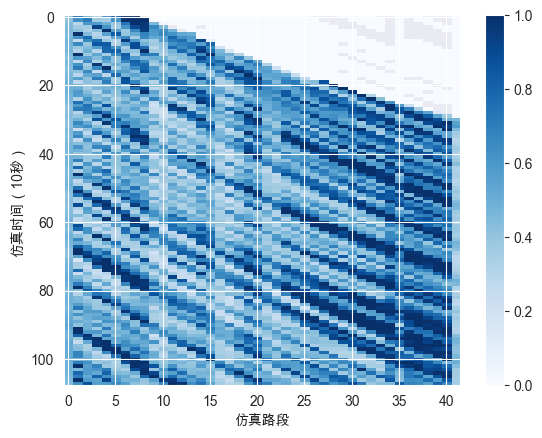

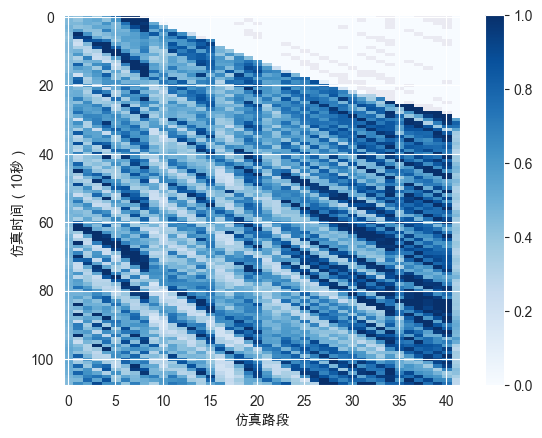

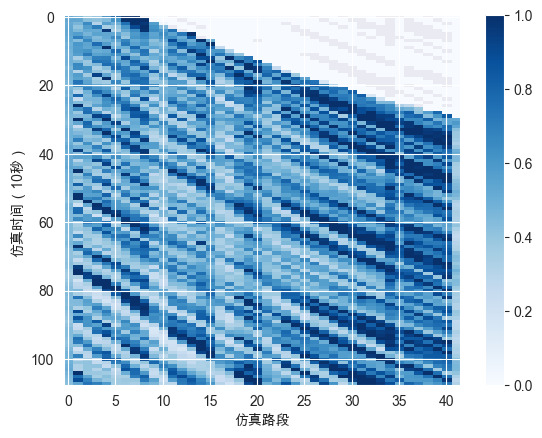

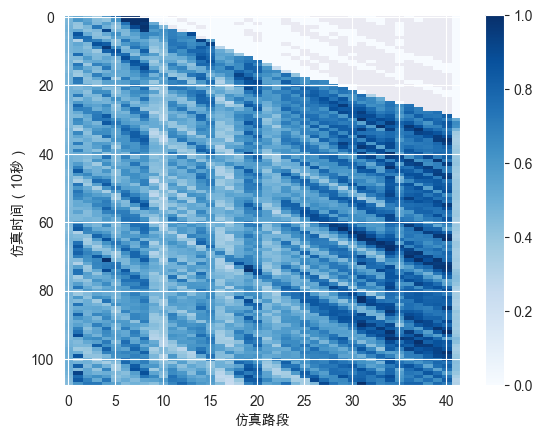

In [18]:
path = './2layer_eval/'
pkl_name = 'evaluation_2layer_adhoc3.pkl'
df_adhoc, p_adhoc = read_pkl(path, pkl_name)
df = (df_adhoc[0] + df_adhoc[1] + df_adhoc[2])/3
list_cols = []
for col in df.columns:
    if 'ratio_cav_plane' in col:
        list_cols.append(col)
data_ratio = df[list_cols].groupby(np.arange(len(df))//10).mean()
data_ratio = np.array(data_ratio)[12:120,:]
fig, ax1 = plt.subplots()
pos = ax1.imshow(data_ratio, vmin=0,vmax=1,aspect='auto',cmap="Blues")
fig.colorbar(pos, ax=ax1)
ax1.set_xlabel('仿真路段')
ax1.set_ylabel('仿真时间（10秒）')
fig.savefig(path + 'output/adhoc_all_cav比例.png')


/var/folders/fk/_rdzs7qj6w3dl2hkfgczh7xr0000gn/T/ipykernel_24521/4149411197.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_eval['n_cav_' + edge] = np.array(record_e[:1700, 2])
/var/folders/fk/_rdzs7qj6w3dl2hkfgczh7xr0000gn/T/ipykernel_24521/4149411197.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_eval['n_platoon_' + edge] = np.array(record_e[:1700, 0])
/var/folders/fk/_rdzs7qj6w3dl2hkfgczh7xr0000gn/T/ipykernel_24521/4149411197.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

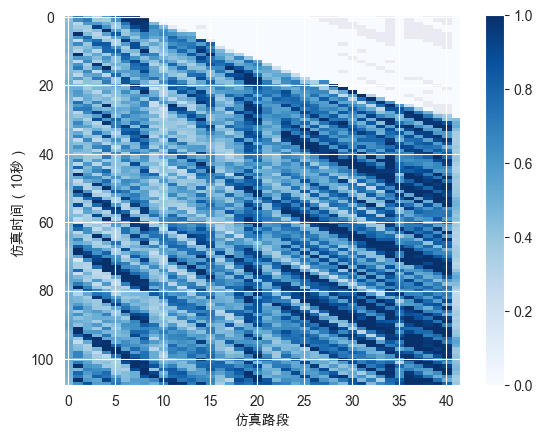

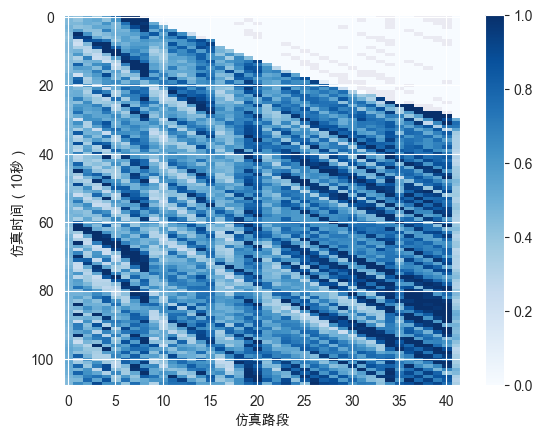

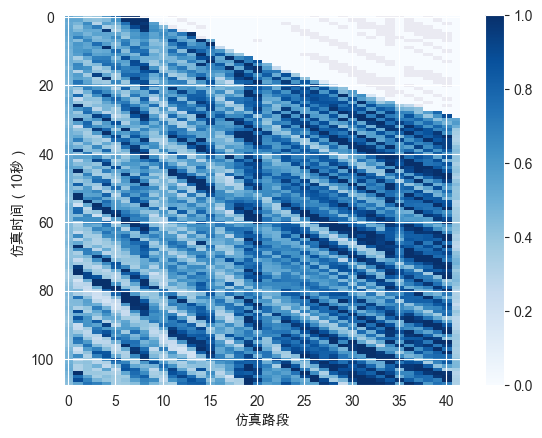

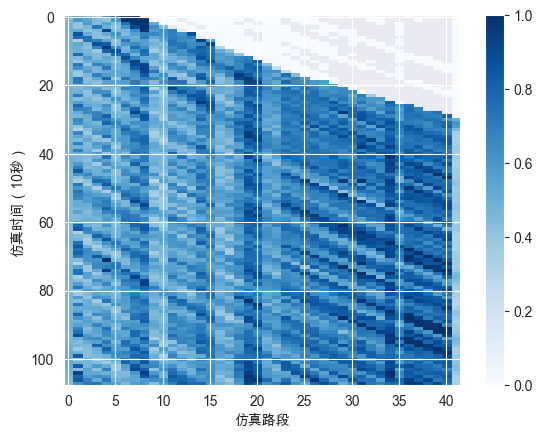

In [19]:
pkl_name = 'evaluation_2layer_score3.pkl'
df_score, p_score = read_pkl(path, pkl_name)
df = (df_score[0] + df_score[1] + df_score[2])/3
list_cols = []
for col in df.columns:
    if 'ratio_cav_plane' in col:
        list_cols.append(col)
data_ratio = df[list_cols].groupby(np.arange(len(df))//10).mean()
data_ratio = np.array(data_ratio)[12:120,:]
fig, ax1 = plt.subplots()
pos = ax1.imshow(data_ratio, vmin=0,vmax=1,aspect='auto',cmap="Blues")
fig.colorbar(pos, ax=ax1)
ax1.set_xlabel('仿真路段')
ax1.set_ylabel('仿真时间（10秒）')
fig.savefig(path + 'output/score_all_cav比例.png')

/var/folders/fk/_rdzs7qj6w3dl2hkfgczh7xr0000gn/T/ipykernel_24521/4149411197.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_eval['n_cav_' + edge] = np.array(record_e[:1700, 2])
/var/folders/fk/_rdzs7qj6w3dl2hkfgczh7xr0000gn/T/ipykernel_24521/4149411197.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_eval['n_platoon_' + edge] = np.array(record_e[:1700, 0])
/var/folders/fk/_rdzs7qj6w3dl2hkfgczh7xr0000gn/T/ipykernel_24521/4149411197.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

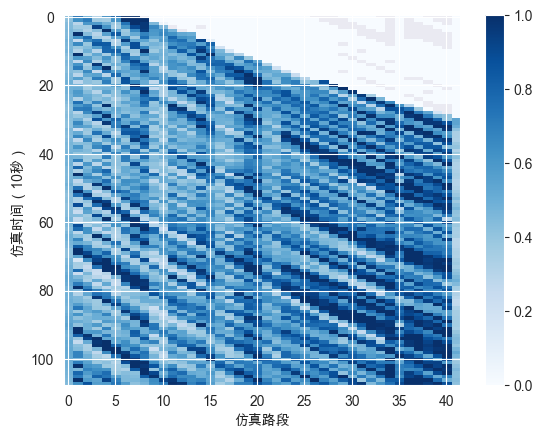

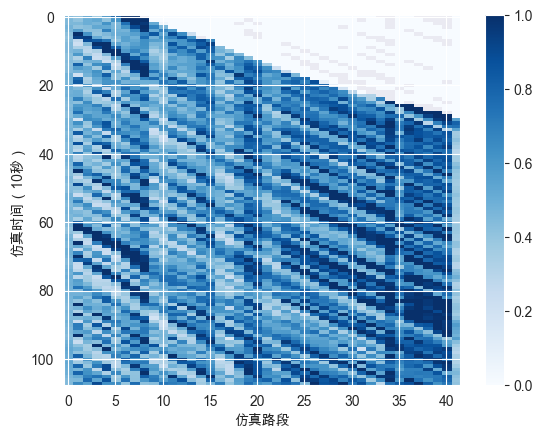

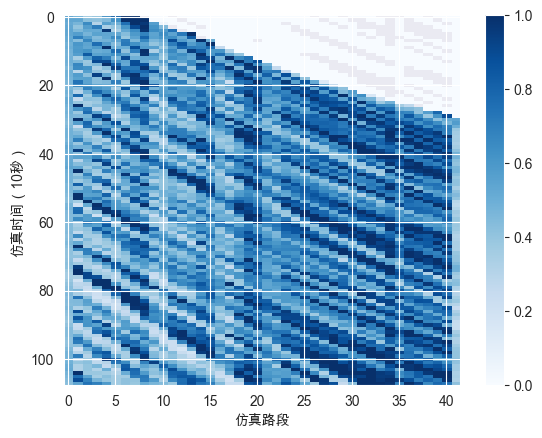

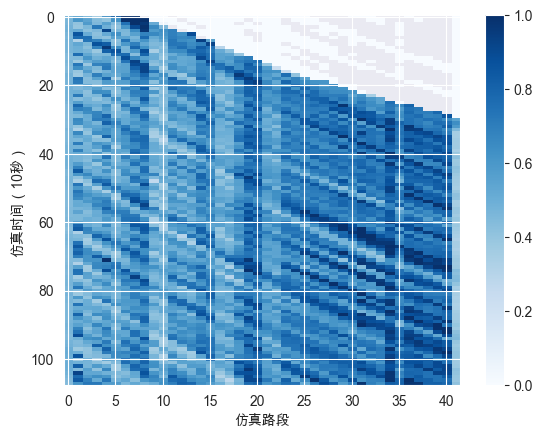

In [20]:
pkl_name = 'evaluation_2layer_dl3.pkl'
df_dl, p_dl = read_pkl(path, pkl_name)
df = (df_dl[0] + df_dl[1] + df_dl[2])/3
list_cols = []
for col in df.columns:
    if 'ratio_cav_plane' in col:
        list_cols.append(col)
data_ratio = df[list_cols].groupby(np.arange(len(df))//10).mean()
data_ratio = np.array(data_ratio)[12:120,:]
fig, ax1 = plt.subplots()
pos = ax1.imshow(data_ratio, vmin=0,vmax=1,aspect='auto',cmap="Blues")
fig.colorbar(pos, ax=ax1)
ax1.set_xlabel('仿真路段')
ax1.set_ylabel('仿真时间（10秒）')
fig.savefig(path + 'output/dl_all_cav比例.png')

In [8]:
def get_avg_len(list_platoon):
    avg_len = []
    list_platoon = list_platoon[600:1200]
    for l in list_platoon:
        avg_len.append(np.array([len(l[p]['members']) for p in l.keys()]).mean())
    return np.array(avg_len).mean()

/var/folders/fk/_rdzs7qj6w3dl2hkfgczh7xr0000gn/T/ipykernel_24521/4149411197.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_eval['n_cav_' + edge] = np.array(record_e[:1700, 2])
/var/folders/fk/_rdzs7qj6w3dl2hkfgczh7xr0000gn/T/ipykernel_24521/4149411197.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_eval['n_platoon_' + edge] = np.array(record_e[:1700, 0])
/var/folders/fk/_rdzs7qj6w3dl2hkfgczh7xr0000gn/T/ipykernel_24521/4149411197.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

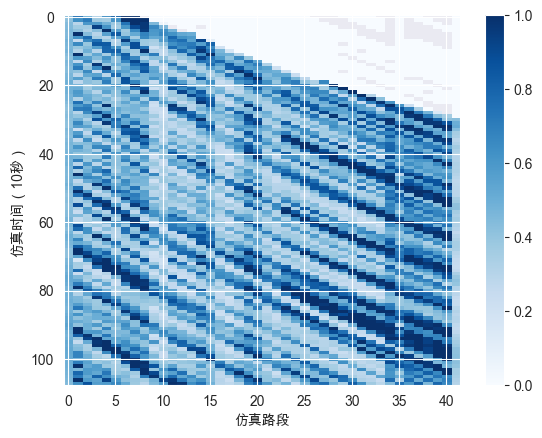

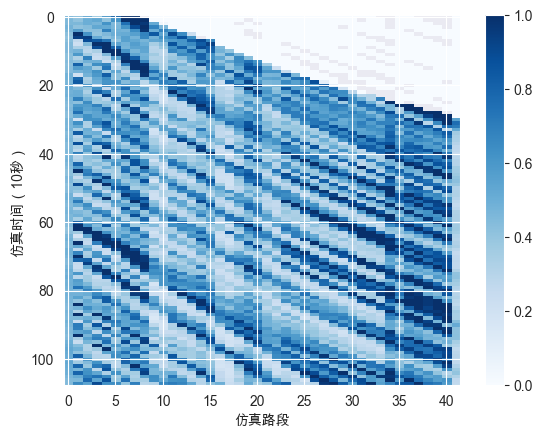

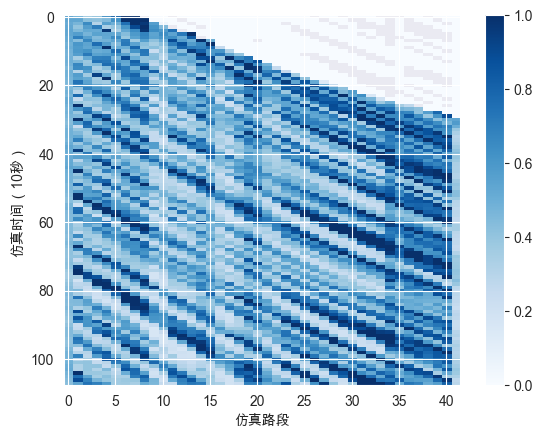

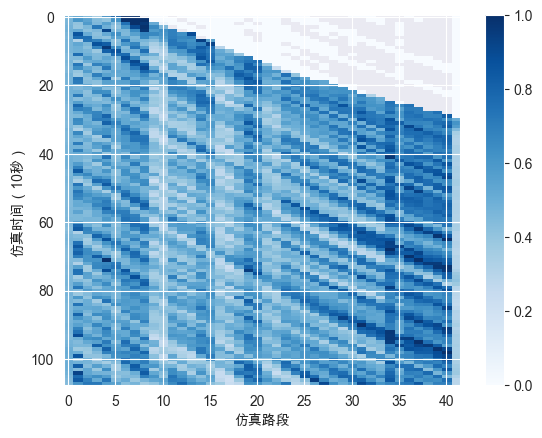

In [21]:
pkl_name = 'evaluation_2layer_nocontrol3.pkl'
df_nc, p_nc = read_pkl(path, pkl_name)
df = (df_nc[0] + df_nc[1] + df_nc[2])/3
list_cols = []
for col in df.columns:
    if 'ratio_cav_plane' in col:
        list_cols.append(col)
data_ratio = df[list_cols].groupby(np.arange(len(df))//10).mean()
data_ratio = np.array(data_ratio)[12:120,:]
fig, ax1 = plt.subplots()
pos = ax1.imshow(data_ratio, vmin=0,vmax=1,aspect='auto',cmap="Blues")
fig.colorbar(pos, ax=ax1)
ax1.set_xlabel('仿真路段')
ax1.set_ylabel('仿真时间（10秒）')
fig.savefig(path + 'output/nc_all_cav比例.png')

/var/folders/fk/_rdzs7qj6w3dl2hkfgczh7xr0000gn/T/ipykernel_24521/4149411197.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_eval['n_cav_' + edge] = np.array(record_e[:1700, 2])
/var/folders/fk/_rdzs7qj6w3dl2hkfgczh7xr0000gn/T/ipykernel_24521/4149411197.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_eval['n_platoon_' + edge] = np.array(record_e[:1700, 0])
/var/folders/fk/_rdzs7qj6w3dl2hkfgczh7xr0000gn/T/ipykernel_24521/4149411197.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

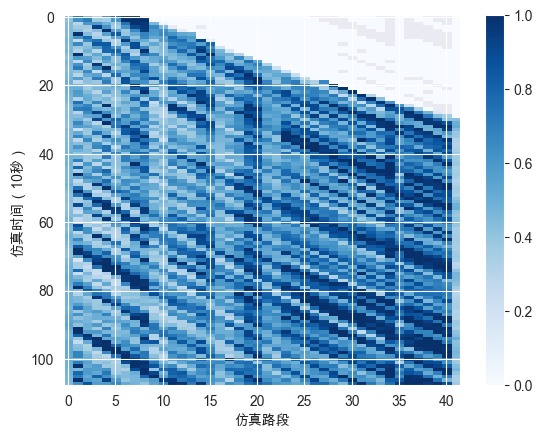

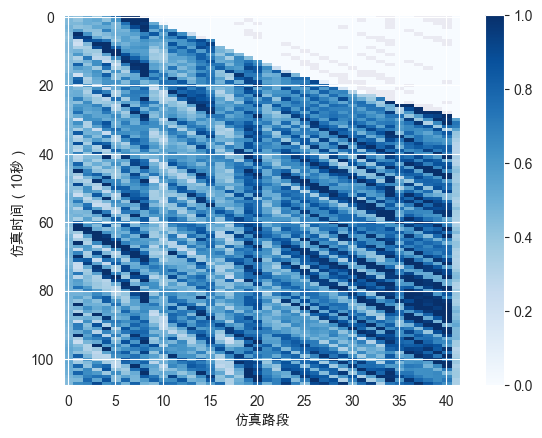

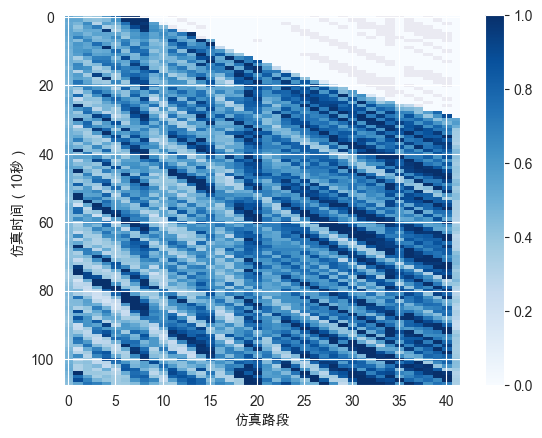

In [10]:
pkl_name = 'evaluation_2layer_score3v2.pkl'
df_s2, p_s2 = read_pkl(path, pkl_name)

In [37]:
df_eval_adhoc = get_result(df_adhoc, p_adhoc)
df_eval_score = get_result(df_score, p_score)
df_eval_dl = get_result(df_dl, p_dl)
df_eval_nc = get_result(df_nc, p_nc)
df_eval_s2 = get_result(df_s2, p_s2)

/var/folders/fk/_rdzs7qj6w3dl2hkfgczh7xr0000gn/T/ipykernel_1643/4064721153.py:8: RuntimeWarning: invalid value encountered in scalar divide
  d_process = [sum(df['processus']) / df['processus_lance'][1699] for df in df_eval]


In [83]:
test = [map_index_dest_list(test[p]['members']) for p in test.keys()]

NameError: name 'test' is not defined

In [38]:
df_eval_nc.mean()

all arrive                        0.000000
all ttd                      465602.000000
arrive non origin platoon      -400.000000
ttd non origin platoon       321587.598560
l_platoon                         2.000000
n_process                         0.000000
d_process                              NaN
n_faillure                        0.000000
n_wrong                           0.000000
ratio_cav_3                       0.540639
ratio_cav_11                      0.502732
ratio_cav_16                      0.384060
ratio_cav_31                      0.567143
ratio_cav_35                      0.575897
ratio                             0.531646
ratio_2                           0.535624
dtype: float64

In [23]:
302737.598560/967

313.06887131334025

In [39]:
df_eval_adhoc.mean()

all arrive                     1366.000000
all ttd                      455722.333333
arrive non origin platoon       966.000000
ttd non origin platoon       311707.931893
l_platoon                         2.209371
n_process                       150.666667
d_process                         7.833489
n_faillure                        1.333333
n_wrong                           0.000000
ratio_cav_3                       0.548397
ratio_cav_11                      0.542273
ratio_cav_16                      0.422801
ratio_cav_31                      0.687757
ratio_cav_35                      0.677373
ratio                             0.473811
ratio_2                           0.481509
dtype: float64

In [40]:
df_eval_score.mean()

all arrive                     1368.000000
all ttd                      446268.666667
arrive non origin platoon       968.000000
ttd non origin platoon       302254.265227
l_platoon                         2.264395
n_process                       142.000000
d_process                         7.607168
n_faillure                        0.000000
n_wrong                           0.000000
ratio_cav_3                       0.546990
ratio_cav_11                      0.603841
ratio_cav_16                      0.505212
ratio_cav_31                      0.730326
ratio_cav_35                      0.706610
ratio                             0.421973
ratio_2                           0.424509
dtype: float64

In [41]:
df_eval_dl.mean()

all arrive                     1367.000000
all ttd                      446752.000000
arrive non origin platoon       967.000000
ttd non origin platoon       302737.598560
l_platoon                         2.251042
n_process                       157.333333
d_process                         6.957924
n_faillure                        0.000000
n_wrong                           0.000000
ratio_cav_3                       0.545347
ratio_cav_11                      0.599838
ratio_cav_16                      0.503495
ratio_cav_31                      0.726153
ratio_cav_35                      0.717595
ratio                             0.423930
ratio_2                           0.425273
dtype: float64

In [ ]:
len_test = [len(p) for p in test]

In [35]:
0.72/0.58- 1

0.24137931034482762

In [ ]:
record_p = []
for p in l:
    record_p += [len(p[x]['members']) for x in p.keys()]

In [ ]:
len(record_p)

In [ ]:
sum(record_p)